In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import snowballstemmer
import string


# Getting the Data From Eksisozluk

I used https://github.com/coluck/eksisozluk-api for scraping the data from
Eksisozluk. It's based on node.js, and it returns data in a json format.

In [2]:
def entries_to_text(entry_dataframe: pd.DataFrame) -> str:
    """A function to merge all of the entries in a page given by the Eksisozluk
    API. Also handles the removal of HTML tags found in the raw results from
    the API."""
    final_text = ''
    for entry in entry_dataframe['body']:
        soup = BeautifulSoup(entry)
        final_text = ' '.join([final_text, soup.get_text()])
    return final_text

In [3]:
def scan_pages_to_str(start_page: int, end_page: int, header_link: str) -> str:
    """A function that uses Eksisozluk API to process all of the entries in the 
    given page range to a string."""
    text_out = ''
    for i in range(start_page, end_page):
        req = requests.get(f"{header_link}?p={i}")
        entries = pd.DataFrame.from_dict(req.json()["entries"])
        text_out = ' '.join([text_out, entries_to_text(entries)])
    return text_out       

In [4]:
def scan_pages_to_df(start_page: int, end_page: int, header_link: str) -> pd.DataFrame:
    """A function that uses Eksisozluk API to process all of the entries in the 
    given page range to a Pandas Data Frame. Also handles the removal of HTML
    tags found in the raw results from the API."""
    df_out = pd.DataFrame()
    soup = BeautifulSoup()
    for i in range(start_page, end_page):
        req = requests.get(f"{header_link}?p={i}")
        entries = pd.DataFrame(req.json()["entries"])
        df_out = pd.concat([entries, df_out])
    df_out = df_out.reset_index(drop=True)
    df_out["cleaned_body"] = [BeautifulSoup(entry).get_text() for entry in df_out["body"]]
    return df_out

In [5]:
def sum_sentiment(df: pd.DataFrame) -> int:
    sentiment = 0
    for i in range(len(df)):
        if df["sentiment_data"][i]["label"] == "positive":
            sentiment += df["sentiment_data"][i]["score"]
        else:
            sentiment -= df["sentiment_data"][i]["score"]
    return sentiment

In [49]:
def signed_sentiments(df: pd.DataFrame) -> np.ndarray:
    s = []
    for i in range(len(df)):
        if df["sentiment_data"][i]["label"] == "positive":
            s.append(df["sentiment_data"][i]["score"])
        else:
            s.append(-df["sentiment_data"][i]["score"])
    return np.array(s)

# Fine-Tuned BERTurk Based Model

## First Round

### Kılıçdaroğlu

Getting some entries about the main opposition candidate:

In [7]:
#Page 4247 corresponds to entries written on May 1
#Page 4404 ends the night before the election day
#kilicdar_data = scan_pages_to_df(4247, 4404, 'http://localhost:3000/api/baslik/kemal-kilicdaroglu--1267550')

In [8]:
#kilicdar_data.to_csv("./datasets/kilicdar_text.csv")

In [29]:
kilicdar_text = pd.read_csv("./datasets/kilicdar_text.csv", index_col=0)

In [30]:
sent_model = AutoModelForSequenceClassification.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
sent_tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
sentiment_pipeline = pipeline("sentiment-analysis", tokenizer=sent_tokenizer, model=sent_model)

Filtering out entries that produce more than 512 tokens.

In [31]:
sent_tokenizer(kilicdar_text["cleaned_body"][0])

{'input_ids': [2, 18238, 1971, 4085, 2417, 20334, 8125, 3926, 2851, 18, 9983, 24637, 1985, 24616, 24637, 1985, 4970, 31461, 1028, 4969, 17595, 2107, 2698, 1028, 3878, 2971, 2985, 18238, 1971, 4085, 18, 18, 18, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [32]:
kilicdar_clean = kilicdar_text.copy()

In [33]:
for i in range(len(kilicdar_clean["cleaned_body"])):
    if len(sent_tokenizer(kilicdar_clean["cleaned_body"][i])["input_ids"]) > 512:
        kilicdar_clean.drop(i, inplace=True)
kilicdar_clean = kilicdar_clean.reset_index(drop=True)

Token indices sequence length is longer than the specified maximum sequence length for this model (713 > 512). Running this sequence through the model will result in indexing errors


In [34]:
sentiment_pipeline(list(kilicdar_clean["cleaned_body"])[:2])

[{'label': 'negative', 'score': 0.9799439311027527},
 {'label': 'negative', 'score': 0.6669246554374695}]

In [35]:
kilicdar_clean_sentiments_small = kilicdar_clean.iloc[:5].copy()
kilicdar_clean_sentiments_small["sentiment_data"] = [sentiment_pipeline(list(kilicdar_clean_sentiments_small["cleaned_body"])[i])[0] for i in range(len(kilicdar_clean_sentiments_small))]
kilicdar_clean_sentiments_small

,id,body,author,author_id,fav_count,created_at,updated_at,cleaned_body,sentiment_data
0,152305089,ayıkla bizi şu bataklıktan be adam.<br><br>eti...,tecrubeli yargic,1313658,2,13.05.2023 15:39,NaN,ayıkla bizi şu bataklıktan be adam.etiğimizle ...,"{'label': 'negative', 'score': 0.9799439311027..."
1,152305377,terörist diyorlar. kerem kılıçdaroğlu askere g...,i never dreamed,1698337,11,13.05.2023 15:46,13.05.2023 15:48,terörist diyorlar. kerem kılıçdaroğlu askere g...,"{'label': 'negative', 'score': 0.6669246554374..."
2,152305469,şimdi türkiye'nin 2. yüzyılının umut kıvılcıml...,giryan,1481508,1,13.05.2023 15:49,NaN,şimdi türkiye'nin 2. yüzyılının umut kıvılcıml...,"{'label': 'positive', 'score': 0.6028804183006..."
3,152305838,"oğlunun bedelli askerlik yapmadan, çürük rapor...",jaheira,1695709,4,13.05.2023 15:59,NaN,"oğlunun bedelli askerlik yapmadan, çürük rapor...","{'label': 'negative', 'score': 0.95930016040802}"
4,152305883,ah o çocuklarla ilgili son paylaşım. biz de ço...,max and mary,1505470,0,13.05.2023 16:01,NaN,ah o çocuklarla ilgili son paylaşım. biz de ço...,"{'label': 'positive', 'score': 0.99774169921875}"


In [16]:
kilicdar_clean_sentiments_small["sentiment_data"][0]

{'label': 'negative', 'score': 0.9799439311027527}

In [17]:
kilicdar_clean_sentiments = kilicdar_clean.copy()
kilicdar_clean_sentiments["sentiment_data"] = [sentiment_pipeline(list(kilicdar_clean_sentiments["cleaned_body"])[i])[0] for i in range(len(kilicdar_clean_sentiments))]

In [18]:
sum_sentiment(kilicdar_clean_sentiments) / len(kilicdar_clean_sentiments)

-0.04901023234483611

In [54]:
kilicdar_signed_sentiments = kilicdar_clean_sentiments.copy()
kilicdar_signed_sentiments["signed_sentiments"] = signed_sentiments(kilicdar_clean_sentiments)
kilicdar_signed_sentiments["signed_sentiments"].describe()

count    1526.000000
mean       -0.049010
std         0.908305
min        -0.999537
25%        -0.976037
50%        -0.593376
75%         0.949721
max         0.999887
Name: signed_sentiments, dtype: float64

In [60]:
kilicdar_sentiment_counts = kilicdar_signed_sentiments.copy()
kilicdar_sentiment_counts["sentiment_label"] = [kilicdar_signed_sentiments["sentiment_data"][i]["label"] for i in range(len(kilicdar_signed_sentiments))]

In [66]:
kilicdar_sentiment_counts["sentiment_label"].value_counts()

sentiment_label
negative    795
positive    731
Name: count, dtype: int64

In [71]:
731 / (795 + 731)

0.47903014416775885

- Maybe count up the positive and negative entries and look at positive/total?
- Visualize the "scores": I predict a bimodal distribution in the signed case, i.e. the model has high confidence most of the time.

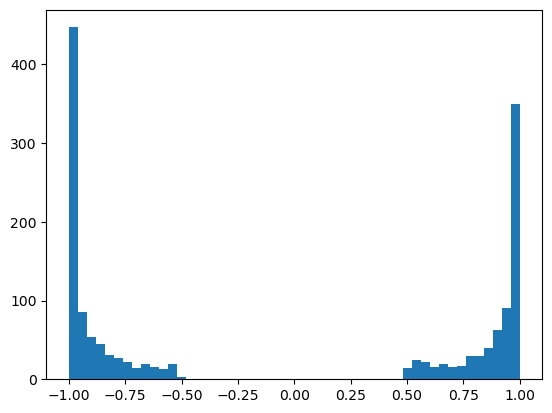

In [77]:
fig, ax = plt.subplots()
ax.hist(kilicdar_signed_sentiments["signed_sentiments"], bins=50)
plt.show()

### Tayyip

In [19]:
#Page 6917 corresponds to entries written on May 1
#Page 7026 ends the night before the election day
#tayyip_data = scan_pages_to_df(6917, 7026, 'http://localhost:3000/api/baslik/recep-tayyip-erdogan--95281')

In [20]:
#tayyip_data.to_csv("./datasets/tayyip_text.csv")

In [36]:
tayyip_text = pd.read_csv("./datasets/tayyip_text.csv", index_col=0)

In [37]:
tayyip_clean = tayyip_text.copy()

In [38]:
for i in range(len(tayyip_clean["cleaned_body"])):
    if len(sent_tokenizer(tayyip_clean["cleaned_body"][i])["input_ids"]) > 512:
        tayyip_clean.drop(i, inplace=True)
tayyip_clean = tayyip_clean.reset_index(drop=True)

In [39]:
tayyip_clean_sentiments = tayyip_clean.copy()
tayyip_clean_sentiments["sentiment_data"] = [sentiment_pipeline(list(tayyip_clean_sentiments["cleaned_body"])[i])[0] for i in range(len(tayyip_clean_sentiments))]

In [53]:
tayyip_signed_sentiments = tayyip_clean_sentiments.copy()
tayyip_signed_sentiments["signed_sentiments"] = signed_sentiments(tayyip_clean_sentiments)
tayyip_signed_sentiments["signed_sentiments"].describe()

count    1069.000000
mean       -0.330573
std         0.853479
min        -0.999374
25%        -0.990500
50%        -0.898757
75%         0.795395
max         0.999883
Name: signed_sentiments, dtype: float64

In [67]:
tayyip_sentiment_counts = tayyip_signed_sentiments.copy()
tayyip_sentiment_counts["sentiment_label"] = [tayyip_signed_sentiments["sentiment_data"][i]["label"] for i in range(len(tayyip_signed_sentiments))]

In [68]:
tayyip_sentiment_counts["sentiment_label"].value_counts()

sentiment_label
negative    718
positive    351
Name: count, dtype: int64

In [70]:
351 / (718 + 351)

0.3283442469597755

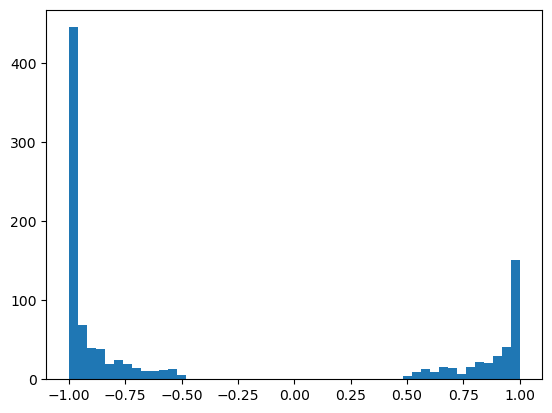

In [91]:
fig, ax = plt.subplots()
ax.hist(tayyip_signed_sentiments["signed_sentiments"], bins=50)
plt.show()

### Muharrem

In [79]:
#Page 3182 corresponds to entries written on May 1
#Page 3481 ends the night before the election day
#muharrem_data = scan_pages_to_df(3182, 3482, 'http://localhost:3000/api/baslik/muharrem-ince--413935')

/var/folders/t3/37z1vnv119jd4057sptnmv900000gn/T/ipykernel_16791/452042521.py:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df_out["cleaned_body"] = [BeautifulSoup(entry).get_text() for entry in df_out["body"]]


In [80]:
#muharrem_data.to_csv("./datasets/muharrem_text.csv")

In [81]:
muharrem_text = pd.read_csv("./datasets/muharrem_text.csv", index_col=0)

In [82]:
muharrem_clean = muharrem_text.copy()

In [83]:
for i in range(len(muharrem_clean["cleaned_body"])):
    if len(sent_tokenizer(muharrem_clean["cleaned_body"][i])["input_ids"]) > 512:
        muharrem_clean.drop(i, inplace=True)
muharrem_clean = muharrem_clean.reset_index(drop=True)

In [84]:
muharrem_clean_sentiments = muharrem_clean.copy()
muharrem_clean_sentiments["sentiment_data"] = [sentiment_pipeline(list(muharrem_clean_sentiments["cleaned_body"])[i])[0] for i in range(len(muharrem_clean_sentiments))]

In [85]:
muharrem_signed_sentiments = muharrem_clean_sentiments.copy()
muharrem_signed_sentiments["signed_sentiments"] = signed_sentiments(muharrem_clean_sentiments)
muharrem_signed_sentiments["signed_sentiments"].describe()

count    2956.000000
mean       -0.553925
std         0.739303
min        -0.999716
25%        -0.995424
50%        -0.969845
75%        -0.628561
max         0.999885
Name: signed_sentiments, dtype: float64

In [86]:
muharrem_sentiment_counts = muharrem_signed_sentiments.copy()
muharrem_sentiment_counts["sentiment_label"] = [muharrem_signed_sentiments["sentiment_data"][i]["label"] for i in range(len(muharrem_signed_sentiments))]

In [87]:
muharrem_sentiment_counts["sentiment_label"].value_counts()

sentiment_label
negative    2318
positive     638
Name: count, dtype: int64

In [88]:
638 / (2318 + 638)

0.2158322056833559

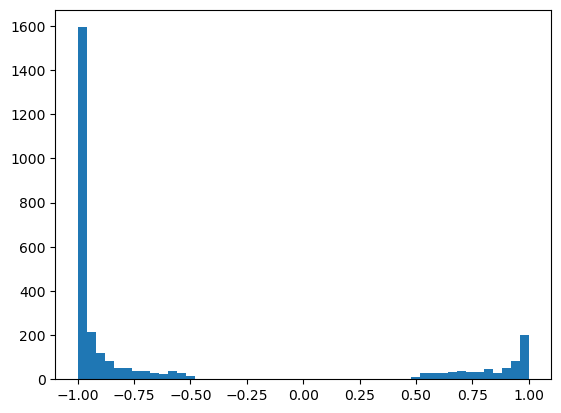

In [92]:
fig, ax = plt.subplots()
ax.hist(muharrem_signed_sentiments["signed_sentiments"], bins=50)
plt.show()

### Sogan

In [93]:
#Page 362 corresponds to entries written on May 1
#Page 634 ends the night before the election day
#sogan_data = scan_pages_to_df(362, 634, 'http://localhost:3000/api/baslik/sinan-ogan--2327957')

/var/folders/t3/37z1vnv119jd4057sptnmv900000gn/T/ipykernel_16791/452042521.py:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df_out["cleaned_body"] = [BeautifulSoup(entry).get_text() for entry in df_out["body"]]


In [94]:
#sogan_data.to_csv("./datasets/sogan_text.csv")

In [95]:
sogan_text = pd.read_csv("./datasets/sogan_text.csv", index_col=0)

In [96]:
sogan_clean = sogan_text.copy()

In [97]:
for i in range(len(sogan_clean["cleaned_body"])):
    if len(sent_tokenizer(sogan_clean["cleaned_body"][i])["input_ids"]) > 512:
        sogan_clean.drop(i, inplace=True)
sogan_clean = sogan_clean.reset_index(drop=True)

In [98]:
sogan_clean_sentiments = sogan_clean.copy()
sogan_clean_sentiments["sentiment_data"] = [sentiment_pipeline(list(sogan_clean_sentiments["cleaned_body"])[i])[0] for i in range(len(sogan_clean_sentiments))]

In [99]:
sogan_signed_sentiments = sogan_clean_sentiments.copy()
sogan_signed_sentiments["signed_sentiments"] = signed_sentiments(sogan_clean_sentiments)
sogan_signed_sentiments["signed_sentiments"].describe()

count    2653.000000
mean       -0.416644
std         0.808013
min        -0.999599
25%        -0.991684
50%        -0.933515
75%         0.618485
max         0.999879
Name: signed_sentiments, dtype: float64

In [100]:
sogan_sentiment_counts = sogan_signed_sentiments.copy()
sogan_sentiment_counts["sentiment_label"] = [sogan_signed_sentiments["sentiment_data"][i]["label"] for i in range(len(sogan_signed_sentiments))]

In [101]:
sogan_sentiment_counts["sentiment_label"].value_counts()

sentiment_label
negative    1892
positive     761
Name: count, dtype: int64

In [103]:
761 / (761 + 1892)

0.2868450810403317

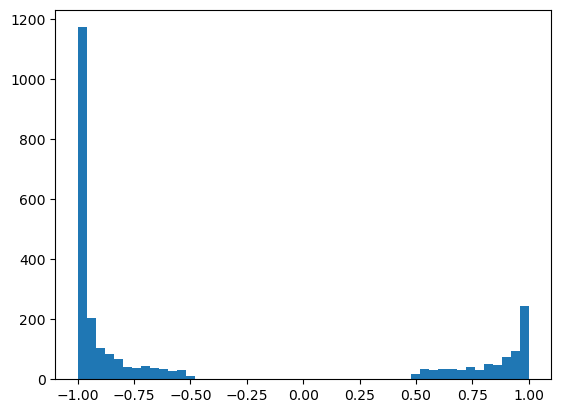

In [102]:
fig, ax = plt.subplots()
ax.hist(sogan_signed_sentiments["signed_sentiments"], bins=50)
plt.show()

## Second Round

### Kılıçdaroğlu

### Tayyip

# Word Clouds

## Kılıçdaroğlu

In [ ]:
kilicdar_str = " ".join(kilicdar_clean["cleaned_body"])

In [ ]:
kilicdar_str_tokenized = word_tokenize(kilicdar_str, language="turkish")

In [ ]:
stop_words = stopwords.words("turkish")
kilicdar_str_tokenized_without_stopwords = [token for token in kilicdar_str_tokenized if not token in stop_words]

In [ ]:
stemmer = snowballstemmer.stemmer("turkish")
kilicdar_stemmed = stemmer.stemWords(kilicdar_str_tokenized_without_stopwords)
kilicdar_stemmed_punctless = [word for word in kilicdar_stemmed if word not in string.punctuation]

Prepare the word cloud.

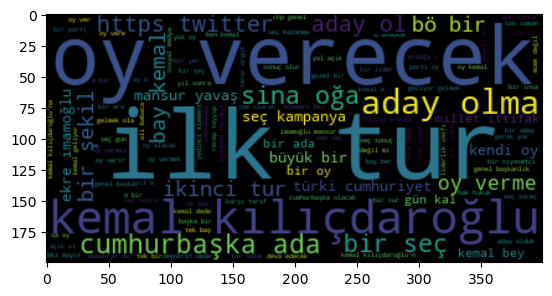

In [ ]:
kilicdar_cloud_str = " ".join(kilicdar_stemmed_punctless)
kilicdar_cloud = WordCloud(collocation_threshold=3).generate(kilicdar_cloud_str)
plt.imshow(kilicdar_cloud, interpolation="bilinear")

## Tayyip

In [ ]:
tayyip_str = " ".join(tayyip_clean["cleaned_body"])
tayyip_str_tokenized = word_tokenize(tayyip_str, language="turkish")
tayyip_str_tokenized_without_stopwords = [token for token in tayyip_str_tokenized if token not in stop_words]
tayyip_stemmed = stemmer.stemWords(tayyip_str_tokenized_without_stopwords)
tayyip_stemmed_punctless = [word for word in tayyip_stemmed if word not in string.punctuation]

Prepare the word cloud.

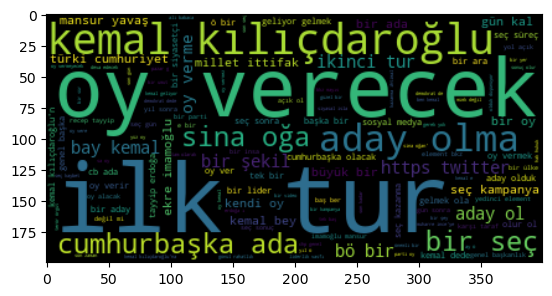

In [ ]:
tayyip_cloud_str = " ".join(kilicdar_stemmed_punctless)
tayyip_cloud = WordCloud(collocation_threshold=3).generate(tayyip_cloud_str)
plt.imshow(tayyip_cloud, interpolation="bilinear")